# Tutorial 2: SSJ approach and toolkit
NBER Heterogeneous-Agent Macro Workshop

June 2025

This notebook aims to give a ground-up introduction to the SSJ toolkit.

Start with our usual imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import sequence_jacobian as sj

# Building blocks of SSJ toolkit: a simple example
The toolkit is built around *blocks*, which are pieces of an economic model, each of which takes in some aggregate inputs and produces some aggregate outputs.

You've already seen `HetBlock`, the most complicated block, in Ludwig's lecture. But there is also a much simpler block, named `SimpleBlock`, where we can specify aggregate equations. We can use Dynare-style notation, with e.g. `(-1)` or `(4)` in parentheses after a variable, to denote that we want to take a lag of 1 or a lead of 4 of the variable in that place.

In [2]:
@sj.simple
def production(A, K, L, alpha):
    Y = A * K(-1)**alpha * L**(1 - alpha)
    MPK = alpha * Y / K(-1)
    MPL = (1 - alpha) * Y / L
    return Y, MPK, MPL

For a `SimpleBlock`, the toolkit will understand as inputs anything that's an input to the function. We name the outputs by giving them names and returning the names. (We couldn't have done just `return K(-1)**alpha * L**(1 - alpha)`, like we might ordinarily try in Python, because then it wouldn't know that this is supposed to be called `Y`.)

In [3]:
print(production)
print(production.inputs)
print(production.outputs)

<SimpleBlock 'production'>
['A', 'K', 'L', 'alpha']
['Y', 'MPK', 'MPL']


Each block (not just a SimpleBlock!) has four core methods that can be called on it: `.steady_state()`, `.impulse_linear()`, `.impulse_nonlinear()`, and `.jacobian()`. Each of these four methods has a "solve" counterpart: `.solve_steady_state()`, `.solve_impulse_linear()`, `.solve_impulse_nonlinear()`, and `.solve_jacobian()`.

### Steady state

First, we'll try `.steady_state()`, which is called on a Python dict that must include all inputs to the block:

In [4]:
calibration = {'A': 1, 'K': 4, 'L': 1, 'alpha': 0.3}
ss = production.steady_state(calibration)
ss

<SteadyStateDict: ['A', 'K', 'L', 'alpha', 'Y', 'MPK', 'MPL']>

As output we get a `SteadyStateDict`, a slightly glorified version of a regular Python dict. The main differences emerge for more complex blocks like `HetBlock`, where the `internals` field of the `SteadyStateDict` contains detailed information (like the micro-level policy function) that doesn't appear at the top level. For now, it's pretty much the same, and indeed we can easily convert it to a regular Python dict:

In [5]:
dict(**ss)

{'A': 1,
 'K': 4,
 'L': 1,
 'alpha': 0.3,
 'Y': 1.515716566510398,
 'MPK': 0.11367874248827985,
 'MPL': 1.0610015965572785}

We might want to hit some calibration targets. For instance, maybe we have a target for the `MPK` of 0.1, given by some measure of user cost $r+\delta$. Maybe we also want to normalize `Y` to 1, while keeping `K` at 4 so that we have a capital-output ratio of 4.

In this situation, we can call `.solve_steady_state()` with an `unknowns` argument that tells what we're solving for and some initial values for the solver, and `targets` telling us what we want to hit.

In [6]:
ss = production.solve_steady_state(calibration, unknowns={'A':1., 'alpha': 0.5}, targets={'Y': 1, 'MPK': 0.1})

Let's verify that we successfully hit our targets (at least up to small numerical error):

In [7]:
ss['Y'], ss['MPK']

(1.0000000000000355, 0.10000000000001079)

What are the values of `A` and `alpha` that we needed for this?

In [8]:
ss['A'], ss['alpha']

(0.5743491774985149, 0.40000000000002894)

Note that `.solve_steady_state()` is a thin wrapper around `.steady_state()`, and in trickier cases it can be useful just use `.steady_state()` and do the nonlinear solution yourself, so that you have more control.

We could do comparative statics across steady states—for instance, seeing how, within this calibrated model, Y, MPK, and MPL will vary as we change L:

In [9]:
Ls = np.linspace(0.5, 1.5, 11)
ss_counterfactuals = [production.steady_state({**ss, 'L': L}) for L in Ls]

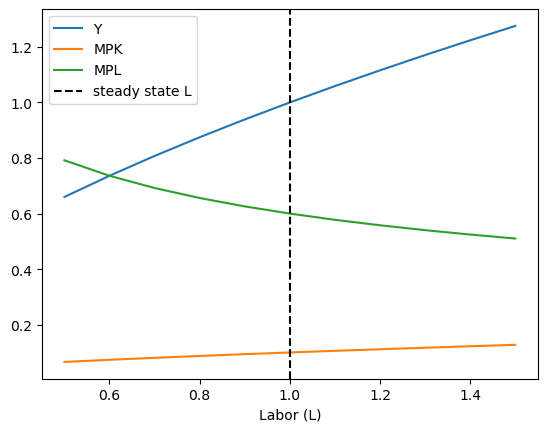

In [10]:
Ys, MPKs, MPLs = zip(*[(ss['Y'], ss['MPK'], ss['MPL']) for ss in ss_counterfactuals])
plt.plot(Ls, Ys, label='Y')
plt.plot(Ls, MPKs, label='MPK')
plt.plot(Ls, MPLs, label='MPL')
plt.xlabel('Labor (L)')
plt.axvline(ss['L'], color='k', linestyle='--', label='steady state L')
plt.legend();

### Jacobians and impulses
Now let's get to more advanced functionality of the toolkit. The `.jacobian()` command can calculate the Jacobian of any *outputs* of a block with respect to any *inputs*.

For more complex blocks, this is just a matrix, and we need to specify the dimension `T`. But for a `SimpleBlock`, that's not strictly necessary:

In [11]:
J = production.jacobian(ss, inputs=['K', 'L'], outputs=['Y', 'MPL'])
J

<JacobianDict outputs=['Y', 'MPL'], inputs=['K', 'L']>

A `JacobianDict` is a nested dict with some special functionality. If we want to extract the Jacobian of `Y` with respect to `K`, for instance, we can write:

In [12]:
J['Y', 'K']

SimpleSparse({(-1, 0): 0.100})

Here the toolkit returns a `SimpleSparse` rather than an ordinary matrix, because the Jacobian of a simple block has such a simple structure (in this case, the diagonal one below the main diagonal being constant at 0.1, with nothing missing) that the toolkit wants to take advantage of that, and avoid wasteful large matrix computations.

We can ask to see an actual matrix version if we want:

In [13]:
J['Y', 'K'].matrix(5)

array([[0. , 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. ]])

A `JacobianDict` can be applied to a dict giving a time-varying sequence of inputs, and it will automatically compute the implied time-varying sequence of outputs. (If it has matrices rather than `SimpleSparse`, the dimension `T` needs to agree.)

In [14]:
dL = 0.5 * 0.9**np.arange(25)
dK = 2 * 0.5**np.arange(25)
impulse = J @ {'K': dK, 'L': dL}
impulse

<ImpulseDict: ['K', 'L', 'Y', 'MPL']>

Now we have an `ImpulseDict`, a slightly glorified dictionary specialized for impulse responses, which includes both the shocks we fed in and the outputs given by the Jacobian. Let's plot what we see. In this case, note the nonmonotonic responses of `Y` and `MPL`, since the capital input is lagged, so the positive shock to capital in the first period doesn't show up:

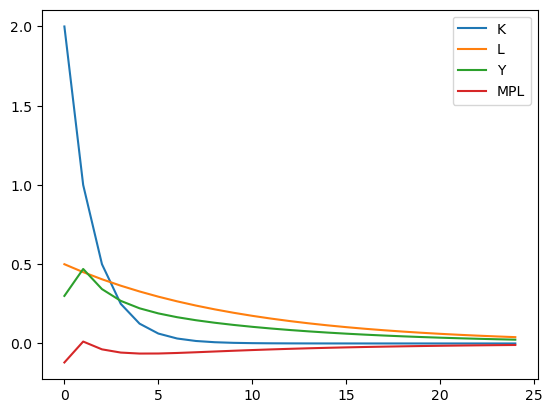

In [15]:
for k, v in impulse.items():
    plt.plot(v, label=k)
plt.legend();

The `.impulse_linear()` method does what we just saw with the Jacobian in a single step, feeding through an impulse to the linearized block:

In [16]:
impulse2 = production.impulse_linear(ss, inputs={'K': dK, 'L': dL}, outputs=['Y', 'MPL'])
impulse2

<ImpulseDict: ['K', 'L', 'Y', 'MPL']>

We can do arithmetic on impulses, so let's subtract these to make sure we get zeros:

In [17]:
impulse_diff = impulse2 - impulse
[np.allclose(impulse_diff[k], 0) for k in impulse_diff.keys()]

[True, True, True, True]

The `.impulse_nonlinear()` method is similar, but looks at the *nonlinear* impulse effect of the input shocks on the output. If we just take the shocks above, which are fairly large relative to the steady state, this will be noticeably different from the linearized dynamics:

In [18]:
impulse_nonlinear = production.impulse_nonlinear(ss, inputs={'K': dK, 'L': dL}, outputs=['Y', 'MPL'])
impulse_nonlinear

<ImpulseDict: ['Y', 'MPL']>

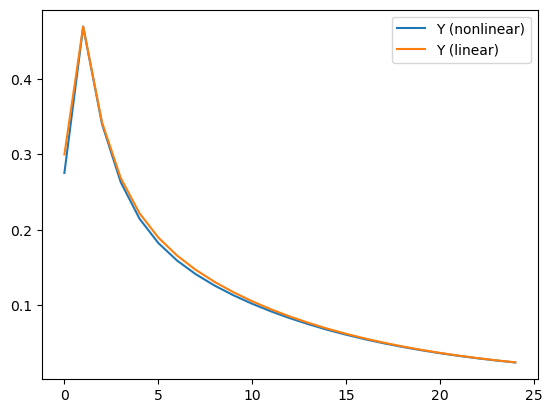

In [19]:
plt.plot(impulse_nonlinear['Y'], label='Y (nonlinear)')
plt.plot(impulse['Y'], label='Y (linear)')
plt.legend();

### Combining and solving blocks
Now let's suppose that we have a labor supply equation that depends just on the current real wage. We'll write this as a SimpleBlock.

In [20]:
@sj.simple
def labor_supply(Lbar, w):
    L = Lbar * w**0.5
    return L

In equilibrium, the real wage has to equal the marginal product of labor MPL. Let's also write this as another very simple SimpleBlock:

In [21]:
@sj.simple
def wage_mpl(w, MPL):
    labor_mkt = w - MPL
    return labor_mkt

We now **combine** these blocks to describe the economy. We can provide the blocks to the toolkit in any order:

In [22]:
model = sj.combine([production, labor_supply, wage_mpl], name='model')
model

<CombinedBlock 'model'>

We then get a `CombinedBlock`, another type of block. The toolkit will automatically sort the blocks internally in the order in which they need to be evaluated, and treat them as a combined whole whenever anything is called on the combinedblock. (We sometimes also use `sj.create_model`, which is mostly just an alias for `sj.combine`.)

In [23]:
model.blocks

[<SimpleBlock 'labor_supply'>,
 <SimpleBlock 'production'>,
 <SimpleBlock 'wage_mpl'>]

We note that `L` is now an output rather than an input, because the first block produces it:

In [24]:
print(model.inputs)
print(model.outputs)

['A', 'K', 'alpha', 'Lbar', 'w']
['Y', 'MPK', 'MPL', 'L', 'labor_mkt']


Let's calibrate the model such that `L` and `Y` are both normalized to 1, and `MPK` is 0.1. Since `model` is a block, just another kind of block, we can call all the same methods on it.

In [25]:
ss = model.solve_steady_state(calibration,
                              unknowns={'A': 1, 'alpha': 0.5, 'Lbar': 1, 'w': 1},
                              targets={'Y': 1, 'L': 1, 'MPK': 0.1, 'labor_mkt': 0})
ss

<SteadyStateDict: ['A', 'K', 'L', 'alpha', 'Lbar', 'w', 'Y', 'MPK', 'MPL', 'labor_mkt']>

Now suppose we want to ask how TFP or labor supply shocks affect labor and output in equilibrium. We still need to enforce that w and MPL equal (i.e. labor market equilibrium), so to get the Jacobians of these on `A`, we need to call `.solve_jacobian()`, with `labor_mkt` as a target:

In [26]:
T = 400
J = model.solve_jacobian(ss, inputs=['A', 'Lbar'], outputs=['Y', 'L', 'w'], unknowns=['w'], targets=['labor_mkt'], T=T)
J

<JacobianDict outputs=['w', 'Y', 'L'], inputs=['A', 'Lbar']>

This doesn't return `SimpleSparse`, although the matrices here turn out to be very simple (all diagonal), because the solving process uses actual matrices. Let's look, for instance, at how output is affected by TFP in equilibrium:

In [27]:
J['Y', 'A'][:5, :5].round(3)

array([[2.176, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 2.176, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 2.176, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 2.176, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 2.176]])

This change reflects a combination of the sensitivity of Y to L, the sensitivity of L to w, and the market-clearing change in w in response to A, plus the direct effect of A on Y. We could manually ask for the Jacobians ourselves if we wanted and then chain them together, but this would be a lot more work:

In [28]:
Y_AL = production.jacobian(ss, inputs=['L', 'A'], outputs=['Y'])
Y_A, Y_L = Y_AL['Y', 'A'], Y_AL['Y', 'L']
L_w = labor_supply.jacobian(ss, inputs=['w'], outputs=['L'])['L', 'w']
L_A = L_w @ J['w', 'A']
Y_AL = Y_L @ L_A + Y_A
Y_AL[:5, :5].round(3)

array([[2.176, 0.   , 0.   , 0.   , 0.   ],
       [0.   , 2.176, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 2.176, 0.   , 0.   ],
       [0.   , 0.   , 0.   , 2.176, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 2.176]])

`.impulse_linear()` and `.impulse_nonlinear()` can similarly be extended to `.solve_impulse_linear()` and `.solve_impulse_nonlinaer()` by adding unknowns and targets.

# Heterogeneous-agent example
Yesterday, Ludwig had us manually specify a HetBlock. A few HetBlocks, however, are included in the SSJ toolkit itself as references. We can try to adapt the SIM hetblock:

In [29]:
hh = sj.hetblocks.hh_sim.hh
print(hh)
print(hh.inputs)
print(hh.outputs)

<HetBlock 'hh'>
['a_grid', 'y', 'r', 'beta', 'eis', 'Pi']
['A', 'C']


We can go look up the actual body of the HetBlock if desired. It has notation similar to what we used yesterday, but with a few minor differences: it says `y` where we had `z` (they mean the same thing, after-tax income by state), and `r` where we had `rp` (they mean the same thing, ex-post returns).

Like before, we'll attach a hetinput that produces after-tax income in terms of the underlying endowment `e` and aggregate after-tax income `Z`.

In [30]:
def income(e, Z):
    y = Z * e
    return y
hh = hh.add_hetinputs([income])
print(hh.inputs)

['a_grid', 'r', 'beta', 'eis', 'Pi', 'e', 'Z']


### Calibration
Yesterday, we also attached hetinputs that created the grids and income process, so that the toolkit understood how to do these steps itself. Another option is just to supply these directly to the steady state function, which is what we'll do here.

In [31]:
a_grid = sj.grids.asset_grid(amin=0, amax=4000, n=400)

# prespecify endowment process
rho_e = 0.91**(1/4)     # annual rho=0.91 from IKC
sd_e = 0.92             # cross-sectional sd from IKC  
e_grid, pi_e, Pi_e = sj.utilities.discretize.markov_rouwenhorst(rho_e, sd_e, 11)

# prespecify beta process (but not betas themselves yet)
q = 0.01        # draw new beta every 25 years
pi_b = np.array([1/4, 1/4, 1/4, 1/4])
Pi_b = (1-q)*np.eye(4) + q*np.outer(np.ones(4), pi_b)

Pi = np.kron(Pi_b, Pi_e)
pi = np.kron(pi_b, pi_e)
e = np.kron(np.ones(4), e_grid)

calibration = dict(r=0.02/4, Z=0.7, eis=1, Pi=Pi, a_grid=a_grid, e=e)

# make beta given beta_hi and dbeta
def make_beta(beta_hi, dbeta):
    # technical detail: add trailing dimension so it works with existing code
    beta = np.kron(np.array([beta_hi-3*dbeta, beta_hi-2*dbeta, beta_hi-dbeta, beta_hi]), np.ones(len(pi_e)))[:, np.newaxis]
    return beta

Now we'll try to do the calibration ourselves. Here, we want a bit more control, so we won't use `.solve_steady_state()`, instead just calling `.steady_state()`.

In [32]:
A_target = 4 * 5  # 500% of annual GDP, so 2000% of quarterly
mpc_target = 0.2

def evaluate_calibration(x):
    print(x)
    try:
        beta = make_beta(x[0], x[1])
        ss = hh.steady_state({**calibration, 'beta': beta})
    except ValueError as e:
        # if steady state raises an error, likely because implied assets infinite
        return 10000, 0
    mpc_labor = hh.jacobian(ss, inputs=['Z'], outputs=['C'], T=2)['C', 'Z'][0, 0]
    print(f"Steady state assets: {ss['A']:.5f}, MPC labor: {mpc_labor:.5f}")
    return ss['A'] - A_target, mpc_labor - mpc_target

In [ ]:
x0 = np.array([1.0, 0.02])
res = optimize.root(lambda x: evaluate_calibration(x), x0, tol=1E-9)

[1.   0.02]
Steady state assets: 10.40263, MPC labor: 0.26605
[1.   0.02]
Steady state assets: 10.40263, MPC labor: 0.26605
[1.   0.02]
Steady state assets: 10.40263, MPC labor: 0.26605
[1.00000001 0.02      ]
Steady state assets: 10.40266, MPC labor: 0.26605
[1.   0.02]
Steady state assets: 10.40263, MPC labor: 0.26605
[1.00378224 0.01794788]
[0.99990359 0.01455798]
Steady state assets: 13.66864, MPC labor: 0.16256
[0.99994135 0.0165279 ]
Steady state assets: 12.14742, MPC labor: 0.19094
[0.99995664 0.01715931]
Steady state assets: 11.76854, MPC labor: 0.19953
[0.9999036  0.01455798]
Steady state assets: 13.66869, MPC labor: 0.16256
[0.99990359 0.01455798]
Steady state assets: 13.66864, MPC labor: 0.16256
[1.00015279 0.01372606]
Steady state assets: 15.49744, MPC labor: 0.11539
[1.00065122 0.01206234]
Steady state assets: 20.83274, MPC labor: 0.08723
[1.00156696 0.01564027]
Steady state assets: 19.93487, MPC labor: 0.15498
[1.00229469 0.01800104]
Steady state assets: 21.56323, MPC lab

In [36]:
calibration['beta'] = make_beta(res.x[0], res.x[1])

### Fiscal policy in equilibrium
Now suppose that we want to solve for the response to a fiscal shock, like yesterday, but that we don't want to manually work with the Intertemporal Keynesian Cross.

We'll instead define a `fiscal` block and `mkt_clearing` block:

In [39]:
@sj.simple
def fiscal(B, r, G, Y):
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T
    deficit = G - T
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = Y - C - G
    return asset_mkt, goods_mkt

Get a combined block, specify the steady state that's consistent with our household side, and verify that market clearing holds in the steady state:

In [47]:
calibration.update(dict(B=20, Y=1, G=0.2))
model = sj.combine([hh, fiscal, mkt_clearing])
ss = model.steady_state(calibration)
ss['asset_mkt'], ss['goods_mkt']

(-4.857083624187908e-08, -3.961540618324655e-07)

Now we can supply an arbitrary sequence of bonds and ask `.solve_impulse_linear()` to get us the effect of the corresponding deficit-financed tax cut on output. It will calculate Jacobians, solve the system, etc. in the background:

In [52]:
dB = 0.95**np.arange(300) # deficit-financed tax cut at date 0, immediately start repaying
imp = model.solve_impulse_linear(ss, inputs={'B': dB}, outputs=['Y', 'T'],
                                unknowns=['Y'], targets=['asset_mkt'])

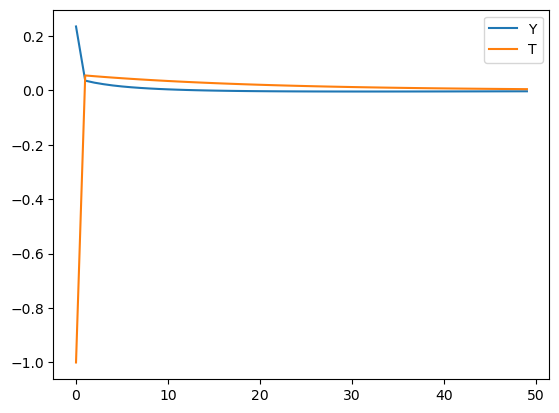

In [53]:
plt.plot(imp['Y'][:50], label='Y')
plt.plot(imp['T'][:50], label='T')
plt.legend()